# Effects of Aggressive and Conservative Strategies for Mechanical Ventilation Liberation
This project aims to use causal inference to estimate the effects of weaning patients off mechanical ventilation sooner or later than normal, following the approach described in [Kennedy, 2018](https://arxiv.org/pdf/1704.00211.pdf). In this study we consider patients who have been on mechanical ventilation for 24 hours (our start criteria).

In [102]:
import pickle
from pprint import pprint

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ALL_WEANING_PREDICTORS is a list of all covariates intially identified as potentially useful in predicting probability of weaning
# group_by_stay is a helper function that groups a dataframe by the column 'stay_id'
from common import (
    ALL_WEANING_PREDICTORS,
    group_by_stay,
)

np.random.seed(0)

First, we exclude variables from consideration if they are missing more than 10% of the time in post-baseline times. Post-baseline in this case means we filter out records from patients at time points before our start criteria.

```
>>> full_df = pd.read_csv('full_weaning_dataset.csv')
>>> post_baseline_df = full_df.loc[full_df['hour_baseline'] >= 1]
>>> post_baseline_df.to_csv('post_baseline_weaning.csv')
```

In [103]:
# Load in the required datasets
# df contains records for the duration of each stay across all stay_ids
# df = pd.read_csv('sampled_post_baseline.csv')
df = pd.read_csv('post_baseline_weaning.csv')
# Cohort contains information about each patient, including
# intime, outtime, deathtime, subject_id, etc
cohort = pd.read_csv('icustays_1.0.csv')
careunits = pd.read_csv('careunits_1.0.csv')
admissions = pd.read_csv('admissions.csv')
cohort = cohort.merge(careunits).merge(admissions)

KeyboardInterrupt: 

## Clean the main dataframe
Overview:
 - Remove patients who have deathtimes before the baseline criteria for the study.
 - Include only the first ICU stays for each patient
 - Fill missing values for certain columns where NaN values just mean 0
 - Create a few columns to track the value of certain variables at time t-1
 - Forward fill most of the columns to remove NaN values, since in most cases NaN simply means the variable wasn't measured at that timepoint
 - Ignore columns who still have a NaN proportion > 0.1
 
First, remove patients whose deathtimes are listed as before the baseline criteria for this study.

Ventilation status being 2 or 5 indicates invasive ventilation or the presence a tracheal tube, respectively. When the status shifts away from these values, it implies the patient was extubated, so adjust control accordingly.

In [ ]:
df.loc[~df['ventilation_status'].isin([2, 5]), 'control'] = 0

In [ ]:
# Remove data points past weaning
df['weaning'] = 1 - df['control']
df['is_past_wean'] = group_by_stay(df, 'weaning').apply(lambda stay: stay.cumsum().cumsum() > 1)
df = df[~df['is_past_wean']]                                   

In [ ]:
# order the df since that's what shahn does next
df.sort_values(['stay_id', 'hour'], ignore_index=True)

,Unnamed: 0,stay_id,hour,ventilator_type,ventilator_mode,peep_set,total_peep_level,tidal_volume_set,tidal_volume_observed,tidal_volume_spontaneous,...,last_rass_max,last_rass_min,last_rass_mean,last_rass_meas,opioid,benzo,propofol,dex,weaning,is_past_wean
0,44,30003598,45,4.0,CMV/ASSIST/AutoFlow,5.0,5.0,600.5,521.0,465.0,...,NaN,NaN,NaN,False,0,0,0,0,0,False
1,45,30003598,46,4.0,CMV/ASSIST/AutoFlow,5.0,5.0,600.5,521.0,465.0,...,NaN,NaN,NaN,False,0,0,0,0,0,False
2,46,30003598,47,4.0,CMV/ASSIST/AutoFlow,5.0,5.0,600.5,521.0,465.0,...,NaN,NaN,NaN,False,0,0,0,0,0,False
3,47,30003598,48,1.0,CMV/ASSIST/AutoFlow,5.0,5.0,600.5,521.0,465.0,...,NaN,NaN,NaN,False,0,0,0,0,0,False
4,48,30003598,49,1.0,CMV/ASSIST/AutoFlow,5.0,5.0,600.5,521.0,465.0,...,NaN,NaN,NaN,False,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360656,2207034,39998622,50,5.0,APV (cmv),5.0,6.0,500.0,537.0,420.0,...,1.0,-1.0,0.0,False,0,0,1,0,0,False
360657,2207035,39998622,51,5.0,APV (cmv),5.0,5.0,500.0,724.0,420.0,...,1.0,-1.0,0.0,True,1,0,1,0,0,False
360658,2207036,39998622,52,5.0,APV (cmv),5.0,5.0,500.0,724.0,420.0,...,1.0,-1.0,0.0,False,0,0,1,0,0,False
360659,2207037,39998622,53,5.0,APV (cmv),5.0,5.0,500.0,724.0,420.0,...,1.0,-1.0,0.0,False,0,0,1,0,0,False


Fill missing urine output (`urine_output`) and vasopressor (`rate_std`) values with 0, since missing entries for these two columns means the value is 0 in this dataset. We do this to make sure we don't accidentally exclude the columns from the dataset because their NaN proportion appears too high, when they should really be included.

In [ ]:
cols_to_impute = ['urine_output', 'last_urine_output', 'rate_std', 'last_rate_std']
df.loc[:, cols_to_impute] = df[cols_to_impute].fillna(0)

Next, we'll create some columns (mostly columns that track the 'last' version of a given variable, i.e. the value at the previous timepoint).

In [ ]:
df['any_vaso'] = df['rate_std'] > 0

for col in ('opioid', 'benzo', 'propofol','dex', 'driving_pressure', 'any_vaso'):
    df[f'last_{col}'] = group_by_stay(df, col).shift(periods=1)

In [ ]:
df = df.merge(cohort[['stay_id', 'deathtime', 'intime']])
# Find the actual time at which the patient's stay started,
# rather than hour `44`, for example
df['baseline_time'] = (
    pd.to_datetime(df['intime']) +
    pd.to_timedelta(df['baseline_hour'], unit='hr')
)
# Identify the stays corresponding to patients whose
# deathtimes occured before the baseline time for the study.
stays_to_omit = df.loc[ 
    df['baseline_time'] > pd.to_datetime(df['deathtime']),
    'stay_id'
].unique()

df = df.loc[~df['stay_id'].isin(stays_to_omit)]

Next, we'll filter the dataframe such that only the first ICU stay for each patient is included.

In [ ]:
# Select subject_id and intime from each valid stay_id in cohort
subjects = cohort.loc[
    cohort['stay_id'].isin(df['stay_id']), ['subject_id', 'stay_id', 'intime']
]
# Sort by subject_id, then by intime to identify which is the first stay
subjects.sort_values(['subject_id', 'intime'], ignore_index=True, inplace=True)
# Get those first stay_ids
first_stay_ids = subjects.groupby('subject_id')['stay_id'].first()
# Filter df (and subjects) to only include those stays
df = df[df['stay_id'].isin(first_stay_ids)]
subjects = subjects[subjects['stay_id'].isin(first_stay_ids)]
# Sort the df
df.sort_values(['stay_id', 'hour'], ignore_index=True, inplace=True)

Then, we forward fill all columns except for `amount` on a per-patient basis. Their values may only be measured occasionally, which is fine since the previous measurement of these values is important, not whether they were measured recently.

In [ ]:
# for c in ALL_WEANING_PREDICTORS:
#     if c == 'amount': continue
#     df.loc[:, c] = group_by_stay(df, c).ffill()

Next, we identify columns to exclude from the analysis on the basis of their NA proportion being too high (we set the threshhold at 0.10).

In [ ]:
LEN_DF = len(df) # cache to avoid recalculating each loop
cols_to_exclude = set()
for c in ALL_WEANING_PREDICTORS:
    na_proportion = df[c].isna().sum() / LEN_DF
    if na_proportion >= 0.1:
        cols_to_exclude.add(c)
        print(f'{c}: {na_proportion}')

marital_status: 0.15031893611692573


Now that we've identified which columns should be excluded from our analysis, we can create a new list of predictors.

In [ ]:
weaning_predictors = [
    c for c in ALL_WEANING_PREDICTORS if c not in cols_to_exclude
]

The next step is to process the data and remove outliers. The `remove_outliers` function essentially writes over implausible values with NaN.

In [ ]:
# df.loc[:, 'amount'] = df['amount']/1000
# df.loc[:, 'last_amount'] = df['last_amount']/1000

# remove_outliers(df)

In [ ]:
for c in weaning_predictors:
    try:
        df[c].fillna(df[c].median(), inplace=True)
    # If a column is a string or object type, the median method will throw a TypeError
    except TypeError:
        # TODO: impute mode for factor datatypes. what's the equivalent in pandas?
        pass

# remove_extremes(df)

Now, we'll standardize our predictors.

In [ ]:
# Standardize predictors
numeric = df[weaning_predictors].select_dtypes(exclude='object').columns
to_standardize = [c for c in numeric if 'last' in c]
df.loc[:, to_standardize] = StandardScaler().fit_transform(df[to_standardize])
# Sanity check to make sure the DataFrame was actually standardized
df[to_standardize].agg(['mean', 'std']).T

,mean,std
last_peep_set,1.894669e-16,1.000002
last_tidal_volume_set,-2.701398e-16,1.000002
last_resp_rate,-3.831521e-17,1.000002
last_peak_insp_pressure,-1.344547e-16,1.000002
last_plateau_pressure,-1.963215e-16,1.000002
last_mean_airway_pressure,2.193458e-16,1.000002
last_minutes_vol,2.293640e-17,1.000002
last_pao2fio2ratio,3.485278e-16,1.000002
last_driving_pressure,-1.428911e-16,1.000002
last_po2,-5.769250e-17,1.000002


Before modeling the probability of weaning, we'll impute medians and remove extreme values from the covariates.

In [ ]:
for c in weaning_predictors:
    if 'last' in c:
        df[c] = np.maximum(-5, np.minimum(df[c], 5))

The final step before modeling is to define our training data. Since we're interested in predicting the probability of starting the first weaning attempt, the relevant data is every timestep up until and including the true start of the first weaning attempt.

For context, any commented-out code in the following cells represents what was/would be run had the notebook used the full dataframe instead of a sampled dataframe.

In [ ]:
# num_days_off_ctrl = group_by_stay(df, 'control').transform(
#     lambda x: (x == 0).cumsum()
# )
# df = df.loc[num_days_off_ctrl <= 1]
# df = df.reset_index(drop=True)

df.to_csv('processed_data.csv')

In [ ]:
MODEL_PARAMS = {
    'penalty': 'l2',
    'max_iter': 2000,
}
# Dataframe checkpoint (loading in full processed dataset)
# df = pd.read_csv('processed_data.csv')
# create our objective column
# df['weaning'] = 1 - df['control']

X = df[weaning_predictors]
y = df['weaning']

for col in X.select_dtypes(include='object'):
    X[col] = LabelEncoder().fit_transform(X[col])

<ipython-input-47-1b4914cada55>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])


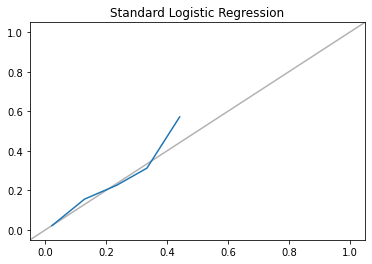

In [ ]:
weaning_predictor = LogisticRegression(**MODEL_PARAMS).fit(X, y)

with open('models/weaning_predictor.pkl', 'wb') as f:
    pickle.dump(weaning_predictor, f)

# # Load in a LogisticRegression model fitted on the full dataset
# with open('models/weaning_predictor.pkl', 'rb') as f:
#     weaning_predictor = pickle.load(f)

create_calibration_curve(
    weaning_predictor, X, y,
    'Standard Logistic Regression',
    save_path='images/calibration_curve.png'
)

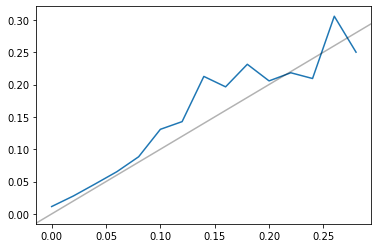

In [107]:
# create a calibration curve
df['p_hat'] = weaning_predictor.predict_proba(X)[:, 1]

prob_pred = []
prob_true = []

resolution = 0.02
xmax = 0.3
for i in range(int(xmax/resolution)):
    prob_true.append(i * resolution)
    prob_pred.append(df.loc[(df['p_hat'] >= resolution * i) & (df['p_hat'] <= resolution * (i + 1)), 'weaning'].mean())

_ , ax = plt.subplots(nrows=1, ncols=1)
plt.plot(prob_true, prob_pred)
ax.axline([0, 0], [0.2, 0.2], color='black', alpha=0.3)

Train a calibrated regressor since the above graph shows that the current predictor is poorly calibrated.

In [ ]:
calibrated_predictor = CalibratedClassifierCV(
    base_estimator=LogisticRegression(**MODEL_PARAMS),
    method='isotonic'
    ).fit(X, y)

with open('models/calibrated_predictor.pkl', 'wb') as f:
    pickle.dump(calibrated_predictor, f)

# # Load in a calibrated LogisticRegression model fitted on the full dataset
# with open('models/calibrated_predictor.pkl', 'rb') as f:
#     calibrated_predictor = pickle.load(f)

# create_calibration_curve(
#     calibrated_predictor, X, y, 
#     'Logistic Regression with Isotonic Calibration',
#     save_path='images/isotonic_calibration_curve.png'
# )

/Users/aman/VSCode Files/earlier-mv-weaning/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


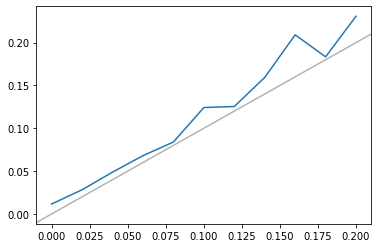

In [108]:
df['p_hat_cal'] = calibrated_predictor.predict_proba(X)[:, 1]

prob_pred = []
prob_true = []

resolution = 0.02
xmax = 0.2
for i in range(int(xmax/resolution) + 1):
    prob_true.append(i * resolution)
    prob_pred.append(df.loc[(df['p_hat_cal'] >= resolution * i) & (df['p_hat_cal'] <= resolution * (i + 1)), 'weaning'].mean())

_ , ax = plt.subplots(nrows=1, ncols=1)
plt.plot(prob_true, prob_pred)
ax.axline([0, 0], [0.2, 0.2], color='black', alpha=0.3)

With our well-calibrated model for the probability of weaning, we can now estimate the causal effect of incrementing this propensity score.

In [123]:
delta_vals = np.around(np.arange(0.5, 2.1, 0.1), decimals=1) # round to remove floating point errors

# For each value of delta:

# 1. Construct time-dependent weights W_t for each subject and timepoint
# 2. Calculate cumulative product weight for each subject across timepoints
# 3. Multiply each cumulative product weight by the outcome
# 4. Take the average of these products to estimate the mean counterfactual outcome

# Create a column with the propensity of a subject at a given timepoint to begin weaning
df.loc[:, 'propensity_score'] = calibrated_predictor.predict_proba(X)[:, 1]

def calculate_estimates(
    deltas,
    data=df,
    treatment_col='weaning',
    propensity_col='propensity_score',
    outcome_col='hospital_expire_flag',
    return_weights=False,
    truncate_weights=True,
    ):
    """
    Calculate estimates for the effect on `outcome_col` of intervening on `A`
    """
    data = data.copy()
    results = {}
    weights = {}
    for delta in deltas:
        A = data[treatment_col]
        pi_hat = data[propensity_col]
        weight_col = f'weights_d{delta}_{outcome_col}'
        # construct time-dependent weights for each subject at each timepoint
        data.loc[:, weight_col] = (
            ((delta * A) + 1 - A) /
            ((delta * pi_hat) + 1 - pi_hat)
        )
        # calculate cumulative product of weights
        cumulative_products = group_by_stay(data, weight_col).prod()
        # truncate cumulative weights at the 99th percentile
        if truncate_weights:
            max_val = cumulative_products.quantile(q=0.99)
            cumulative_products = np.minimum(cumulative_products, max_val)
        # save the weights
        weights[delta] = cumulative_products
        # multiply by outcome
        weighted_products = cumulative_products.multiply(
            group_by_stay(data, outcome_col).first()
        )
        # average over subjects and add to results
        results[delta] = weighted_products.mean()
    return (results, weights) if return_weights else results


First, examine time until weaning results.

In [116]:
# time until weaning outcome
grouped = group_by_stay(df, 'weaning')
df['time_until_wean'] = (grouped
    # Apply the .max() and .size() functions to the weaning groups
    # This determines 1. whether weaning occured
    # and 2. the number of hours at which weaning began (if it did)
    .agg(['max', 'size'])
    # If weaning did occur, return the number of hours after baseline with it occured
    # Otherwise, we set the value to 720 hours
    .apply(lambda row: row['size'] if row['max'] else 720, axis=1)
    # Repeat rows to ensure the size of the array matches what's in the dataframe
    .repeat(grouped.size())
    # Reset index so column can be inserted into the dataframe properly
    .reset_index(drop=True)
)

In [117]:
time_until_wean_results = calculate_estimates(delta_vals, outcome_col='time_until_wean')
pprint(time_until_wean_results)

{0.5: 72.973649425188,
 0.6: 65.7496713131525,
 0.7: 59.060645591941054,
 0.8: 53.21267305489172,
 0.9: 48.23995410307622,
 1.0: 44.05771559262771,
 1.1: 40.220958052712284,
 1.2: 37.23536378842845,
 1.3: 34.775009347164506,
 1.4: 32.681987062737264,
 1.5: 30.865896602165215,
 1.6: 29.26807472555956,
 1.7: 27.84722567727777,
 1.8: 26.572756625762633,
 1.9: 25.421230651938565,
 2.0: 24.37425944551152}


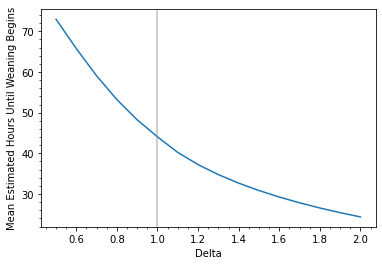

In [120]:
plt.xlabel('Delta')
plt.ylabel('Mean Estimated Hours Until Weaning Begins')
plt.plot(time_until_wean_results.keys(), time_until_wean_results.values())
plt.axvline(1, color='grey', alpha=0.5)
plt.minorticks_on()
plt.savefig('images/time_until_wean_results.png', facecolor='white')
plt.show()

Next, mortality.

In [289]:
# mortality
mortality_results, weights = calculate_estimates(delta_vals, return_weights=True)

pprint(mortality_results)

{0.5: 0.3349789308983709,
 0.6: 0.33722795764366953,
 0.7: 0.3372380855147004,
 0.8: 0.33644840098622425,
 0.9: 0.3355223409955113,
 1.0: 0.334723530203149,
 1.1: 0.33378903581315067,
 1.2: 0.3333431010974809,
 1.3: 0.33314637141283127,
 1.4: 0.33308241689986035,
 1.5: 0.33308663895095264,
 1.6: 0.33312009428729095,
 1.7: 0.33315831621417474,
 1.8: 0.3331857506983772,
 1.9: 0.33319262309886594,
 2.0: 0.3331730186039036}


To get a better idea of the results, we'll plot a line graph of the estimated outcomes for each value of delta.

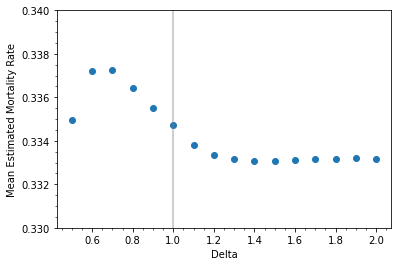

In [290]:
plt.xlabel('Delta')
plt.ylabel('Mean Estimated Mortality Rate')
plt.scatter(mortality_results.keys(), mortality_results.values())
plt.axvline(1, color='grey', alpha=0.5)
plt.ylim(0.33, 0.34)
plt.minorticks_on()
plt.savefig('images/mortality_results.png', facecolor='white')
plt.show()

Now we can rerun our analysis with the desired outcome being ICU-free days.

In [176]:
# 1. find baseline time
# 2. find how many days in the 30 days post-baseline the patient was alive and not in the icu
# assumptions:
#   if the patient didn't die in a hospital stay, they didn't die
#   if they died in hospital, assume discharge time is time of death

# Merge dataframe containing in and out time
baseline_hour_df = cohort.loc[
    :, ['stay_id', 'intime', 'outtime', 'subject_id']
    ].merge(
        df.loc[df['hour_baseline'] == 1, ['stay_id', 'baseline_hour', 'baseline_time']]
    )

icu_duration_df = cohort.merge(
    baseline_hour_df.loc[:, ['subject_id', 'baseline_time']].drop_duplicates()
    )

In [ ]:
# convert dtype of columns with datetimes from object to datetimes
for time_col in ('intime', 'outtime', 'deathtime'):
    icu_duration_df[time_col] = pd.to_datetime(icu_duration_df[time_col])

icu_duration_df['max_time'] = icu_duration_df['baseline_time'] + pd.Timedelta(30, unit="days")
# remove ones where outtime <= baseline_time
icu_duration_df = icu_duration_df.loc[icu_duration_df['outtime'] > icu_duration_df['baseline_time']]
# remove rows with max_time <= intime
icu_duration_df = icu_duration_df.loc[icu_duration_df['max_time'] > icu_duration_df['intime']]

In [ ]:
# Calculate duration of each stay
icu_duration_df = icu_duration_df.sort_values('subject_id')
stay_start = np.maximum(icu_duration_df['intime'], icu_duration_df['baseline_time'])
stay_end = np.minimum(icu_duration_df['outtime'], icu_duration_df['max_time'])
icu_duration_df['icu_stay_durations'] = stay_end - stay_start

In [231]:
icu_duration_df['death_day'] = icu_duration_df['deathtime'] - icu_duration_df['baseline_time']
# fill all entries with deathtime before baseline_time with 0
icu_duration_df.loc[icu_duration_df['death_day'] < pd.to_timedelta(0), 'death_day'] = pd.to_timedelta(0)
# fill all entries with NaN deathtime with a dummy value
icu_duration_df['death_day'].fillna(pd.Timedelta(100000, unit="days"), inplace=True)

In [235]:
max_val = pd.Timedelta(30, "days")
icu_duration_df['max'] = icu_duration_df['death_day'].where(icu_duration_df['death_day'] <= max_val, max_val)
max_df = icu_duration_df[['subject_id', 'max']].drop_duplicates()
max_df = max_df.groupby('subject_id', as_index=False).min()

In [257]:
duration_df = icu_duration_df.groupby('subject_id', as_index=False)['icu_stay_durations'].sum()

In [274]:
icu_outcome_df = max_df.merge(duration_df)
icu_outcome_df.rename(columns = {'icu_stay_durations' : 'icu_duration'}, inplace=True)

In [286]:
# construct outcome column (take ceil of the time difference to the nearest day)
icu_outcome_df['outcome'] = (icu_outcome_df['max'] - icu_outcome_df['icu_duration']).dt.ceil('d')
# merge with subjects to get stay id
icu_outcome_df = icu_outcome_df.merge(subjects[['subject_id', 'stay_id']])
icu_outcome_df.sort_values('stay_id', inplace=True)

Calculate estimates!

In [320]:
counterfactual_icu_free_days = {}
outcome = icu_outcome_df.set_index('stay_id')['outcome'].dt.days
for d in delta_vals:
    counterfactual_icu_free_days[d] = (weights[d] * outcome).mean()

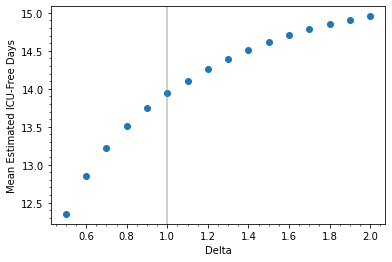

In [324]:
plt.xlabel('Delta')
plt.ylabel('Mean Estimated ICU-Free Days')
plt.scatter(counterfactual_icu_free_days.keys(), counterfactual_icu_free_days.values())
plt.axvline(1, color='grey', alpha=0.5)
# plt.ylim(0.33, 0.34)
plt.minorticks_on()
plt.savefig('images/icu_free_results.png', facecolor='white')
plt.show()

Up until this point, all results verified against R code!

Next: bootstrap to determine variability.

In [128]:
N_BOOTSTRAPS = 100
outcome_estimates = {d: [] for d in delta_vals}

stays = df['stay_id'].unique()

def get_bootstrap_sample():
    """Randomly sample from the dataframe, keeping the number of stays the same."""
    sampled_stays = np.random.choice(stays, size=stays.shape, replace=True)
    # Determine how many times each stay should be repeated (since we sample w/replacement)
    num_repeats = {s: 0 for s in sampled_stays}
    for s in sampled_stays:
        num_repeats[s] += 1
    # Choose only the selected stays
    curr_data = df.loc[df['stay_id'].isin(sampled_stays)]
    indices = []
    for stay, idxs in group_by_stay(curr_data).groups.items():
        indices += (num_repeats[stay] * list(idxs))
    return curr_data.reindex(indices)

for i in range(N_BOOTSTRAPS):
    r = calculate_estimates(
        delta_vals,
        data=get_bootstrap_sample(),
    )
    for delta, estimate in r.items():
        outcome_estimates[delta].append(estimate)

outcome_estimates = pd.DataFrame(outcome_estimates)
# outcome_estimates.to_csv('outcome_estimates.csv')
outcome_estimates.head()

,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0
0,0.457909,0.402063,0.364967,0.342731,0.331746,0.328052,0.328325,0.332323,0.338262,0.345428,0.353457,0.362147,0.371220,0.380816,0.390698,0.401026
1,0.474154,0.414744,0.376292,0.354188,0.344120,0.341505,0.342623,0.347181,0.353536,0.361062,0.369394,0.378283,0.387637,0.397566,0.407860,0.417834
2,0.425234,0.388179,0.361388,0.345133,0.336842,0.334183,0.334630,0.338348,0.343764,0.350241,0.357389,0.365017,0.372945,0.381234,0.389702,0.398295
3,0.491602,0.419705,0.375781,0.351622,0.339117,0.334396,0.333914,0.337260,0.342562,0.349035,0.356216,0.364049,0.372328,0.380860,0.389755,0.398903
4,0.475320,0.418236,0.378423,0.355064,0.343519,0.339602,0.339946,0.343654,0.349362,0.356296,0.364048,0.372464,0.381441,0.390822,0.400538,0.410537


In [129]:
outcome_estimates.mean()

0.5    0.467399
0.6    0.409106
0.7    0.370506
0.8    0.348270
0.9    0.337486
1.0    0.334096
1.1    0.334711
1.2    0.338798
1.3    0.344747
1.4    0.351863
1.5    0.359762
1.6    0.368217
1.7    0.377101
1.8    0.386314
1.9    0.395772
2.0    0.405440
dtype: float64

In [130]:
to_plot = outcome_estimates.iloc[:, 2:17]

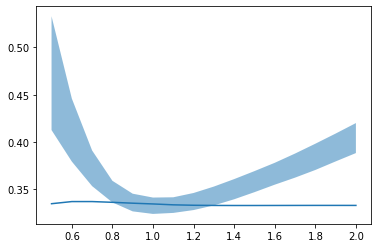

In [133]:
bounds = outcome_estimates.quantile(0.025), outcome_estimates.quantile(0.975)
# bounds = outcome_estimates.min(), outcome_estimates.max()
plt.fill_between(delta_vals, bounds[0], bounds[1], alpha=0.5)
plt.plot(mortality_results.keys(), mortality_results.values())
plt.show()

Now that we have an understanding of the variability of our estimates, we'll run one final analysis. This time, instead of looking at the impact of weaning interventions on mortality, our outcome of interest will be the amount of time until first weaning attempt. The goal of this is to see how much of an impact the interventions actually have on the time before first attempt.

In [ ]:
grouped = group_by_stay(df, 'weaning')
df['time_until_wean'] = (grouped
    # Apply the .max() and .size() functions to the weaning groups
    # This determines 1. whether weaning occured
    # and 2. the number of hours at which weaning began (if it did)
    .agg(['max', 'size'])
    # If weaning did occur, return the number of hours after baseline with it occured
    # Otherwise, we set the value to 720 hours
    .apply(lambda row: row['size'] if row['max'] else 720, axis=1)
    # Repeat rows to ensure the size of the array matches what's in the dataframe
    .repeat(grouped.size())
    # Reset index so column can be inserted into the dataframe properly
    .reset_index(drop=True)
)

In [ ]:
time_until_wean_results = calculate_estimates(delta_vals, outcome_col='time_until_wean')
pprint(time_until_wean_results)

{0.5: 40.26349090669701,
 0.6: 36.40434666461345,
 0.7: 32.89950168000707,
 0.8: 29.93177644269899,
 0.9: 27.393641875978574,
 1.0: 25.225469728601393,
 1.1: 23.171979261007245,
 1.2: 21.55431868841622,
 1.3: 20.20713227161252,
 1.4: 19.050516748678056,
 1.5: 18.03818963829559,
 1.6: 17.140031072711746,
 1.7: 16.334901039484713,
 1.8: 15.607197249956442,
 1.9: 14.944992427376341,
 2.0: 14.338932216615847}


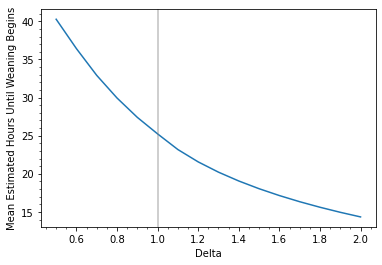

In [ ]:
plt.xlabel('Delta')
plt.ylabel('Mean Estimated Hours Until Weaning Begins')
plt.plot(time_until_wean_results.keys(), time_until_wean_results.values())
plt.axvline(1, color='grey', alpha=0.5)
plt.minorticks_on()
plt.savefig('images/time_until_wean_results.png', facecolor='white')
plt.show()